In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [11]:
# Define variables
CUDA = True
DATA_PATH = './data'
batch_size = 128
epochs = 100
lr = 2e-4
classes = 10
channels = 1
img_size = 64
latent_dim = 100
log_interval = 100

In [4]:
seed = 42
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.6.0+cu124
CUDA version: 12.4



In [5]:
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(img_size),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.99MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


In [6]:
# latent_dim is for noise label 

class Generator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Generator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        # label is first converted into a dense vector (an embedding) by self.label_embedding
        self.label_embedding = nn.Embedding(self.classes, self.classes)

        self.model = nn.Sequential(
            *self._create_layer(self.latent_dim + self.classes, 128, False),
            *self._create_layer(128, 256),
            *self._create_layer(256, 512),
            *self._create_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def _create_layer(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, noise, labels):
        z = torch.cat((self.label_embedding(labels), noise), -1)
        x = self.model(z)
        x = x.view(x.size(0), *self.img_shape)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Discriminator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()

        self.model = nn.Sequential(
            *self._create_layer(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer(1024, 512, True, True),
            *self._create_layer(512, 256, True, True),
            *self._create_layer(256, 128, False, False),
            *self._create_layer(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, image, labels):
        x = torch.cat((image.view(image.size(0), -1), self.label_embedding(labels)), -1)
        return self.model(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [8]:
# Setup the generator and the discriminator
netG = Generator(classes, channels, img_size, latent_dim).to(device)
print(netG)
netD = Discriminator(classes, channels, img_size, latent_dim).to(device)
print(netD)

# Setup Adam optimizers for both G and D
optim_D = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optim_G = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=4096, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(10, 10)
  (adv_loss): BCELoss()
  (model): Sequential(
    (

In [12]:
# Train
img_list = []

netG.train()
netD.train()
viz_z = torch.zeros((batch_size, latent_dim), device=device)
viz_noise = torch.randn(batch_size, latent_dim, device=device)
nrows = batch_size // 8
viz_label = torch.LongTensor(np.array([num for _ in range(nrows) for num in range(8)])).to(device)

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        batch_size = data.size(0)
        real_label = torch.full((batch_size, 1), 1., device=device)
        fake_label = torch.full((batch_size, 1), 0., device=device)

        # Train G
        netG.zero_grad()
        z_noise = torch.randn(batch_size, latent_dim, device=device)
        x_fake_labels = torch.randint(0, classes, (batch_size,), device=device)
        x_fake = netG(z_noise, x_fake_labels)
        y_fake_g = netD(x_fake, x_fake_labels)
        g_loss = netD.loss(y_fake_g, real_label)
        g_loss.backward()
        optim_G.step()

        # Train D
        netD.zero_grad()
        y_real = netD(data, target)
        d_real_loss = netD.loss(y_real, real_label)
        y_fake_d = netD(x_fake.detach(), x_fake_labels)
        d_fake_loss = netD.loss(y_fake_d, fake_label)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        
        if batch_idx % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f}'.format(
                        epoch, batch_idx, len(dataloader),
                        d_loss.mean().item(),
                        g_loss.mean().item()))
            
            with torch.no_grad():
                viz_sample = netG(viz_noise, viz_label)
                img_list.append(vutils.make_grid(viz_sample, normalize=True))

Epoch 0 [100/469] loss_D: 0.5608 loss_G: 2.3698
Epoch 0 [200/469] loss_D: 0.5214 loss_G: 0.9214
Epoch 0 [300/469] loss_D: 0.6665 loss_G: 1.0898
Epoch 0 [400/469] loss_D: 0.5882 loss_G: 0.6692
Epoch 1 [100/469] loss_D: 0.3855 loss_G: 1.8927
Epoch 1 [200/469] loss_D: 0.6788 loss_G: 0.4473
Epoch 1 [300/469] loss_D: 0.6326 loss_G: 0.7932
Epoch 1 [400/469] loss_D: 0.4836 loss_G: 2.8229
Epoch 2 [100/469] loss_D: 0.9425 loss_G: 0.2185
Epoch 2 [200/469] loss_D: 0.4997 loss_G: 1.4303
Epoch 2 [300/469] loss_D: 0.5534 loss_G: 1.2158
Epoch 2 [400/469] loss_D: 0.5629 loss_G: 1.1564
Epoch 3 [100/469] loss_D: 0.4253 loss_G: 2.0887
Epoch 3 [200/469] loss_D: 0.5482 loss_G: 1.3992
Epoch 3 [300/469] loss_D: 0.5720 loss_G: 0.8962
Epoch 3 [400/469] loss_D: 0.5051 loss_G: 1.3434
Epoch 4 [100/469] loss_D: 0.5978 loss_G: 0.8264
Epoch 4 [200/469] loss_D: 0.5163 loss_G: 1.0926
Epoch 4 [300/469] loss_D: 0.5783 loss_G: 1.2317
Epoch 4 [400/469] loss_D: 0.7008 loss_G: 0.3956
Epoch 5 [100/469] loss_D: 0.4991 loss_G:

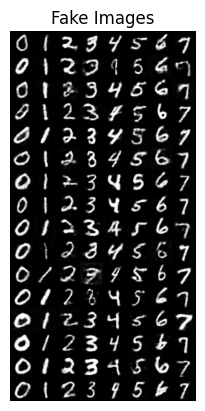

In [13]:
img_array = img_list[-1].detach().cpu().numpy().transpose(1, 2, 0)

plt.imshow(img_array)
# The rest of your code
plt.axis("off")
plt.title("Fake Images")
plt.show()